In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import convert
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import time_determination as term
from src.utils.production_process import gen_deadline as gen_deadline
from src.utils.production_process import filter as process_filter

# Solver Model
from src.models.cp import lateness_scheduling as cp_late_schedule
from src.models.cp import lateness_rescheduling as cp_late_reschedule
import src.models.heuristics.fcfs as fcfs


# Simulation
from src.simulation.ProductionSimulation import ProductionSimulation


# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [3]:
max_time = 60 * 30 # 30 min

## Laden der Produktionsaufträge

In [4]:
data_path = get_path("data", "cp_lateness")
file_template = "02_{text}.csv"

In [5]:
file = file_template.format(text= "all_job_times")

df_job_times_all = pd.read_csv(data_path / file)
df_job_times_all['Job'] = df_job_times_all['Job'].astype(str)
df_job_times_all

,Job,Production_Plan_ID,Arrival,Deadline,Ready Time,Processing Time,Slack
0,0,0,49,2027,1440,395,192
1,1,1,130,2683,1440,510,733
2,2,2,151,2994,1440,568,986
3,3,3,226,3505,1440,655,1410
4,4,4,386,2353,1440,393,520
...,...,...,...,...,...,...,...
415,415,6,28598,30681,28800,416,1465
416,416,4,28606,30573,28800,393,1380
417,417,5,28722,31205,28800,496,1909
418,418,7,28746,31444,28800,539,2105


In [6]:
file = file_template.format(text= "all_jssp")
df_jssp_all = pd.read_csv(data_path / file)
df_jssp_all['Job'] = df_jssp_all['Job'].astype(str)
df_jssp_all

,Job,Production_Plan_ID,Operation,Machine,Processing Time
0,0,0,0,M00,29
1,0,0,1,M01,78
2,0,0,2,M02,9
3,0,0,3,M03,36
4,0,0,4,M04,49
...,...,...,...,...,...
4195,419,8,5,M09,11
4196,419,8,6,M06,40
4197,419,8,7,M07,89
4198,419,8,8,M04,26


## Laden der Initialisierungsdaten vom Tag 1

In [7]:
day_numb = 1

In [8]:
file = file_template.format(text= f"schedule_{day_numb:02d}_init")
df_schedule = pd.read_csv(data_path / file)
df_schedule 

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,3,3,0,M01,236,2443,1440,81,1521,-922,0,922
1,12,8,0,M00,992,2959,1440,76,1516,-1443,0,1443
2,15,7,0,M02,1193,3397,1440,31,1471,-1926,0,1926
3,5,5,0,M02,485,3488,1471,84,1555,-1933,0,1933
4,1,1,0,M00,136,2999,1516,43,1559,-1440,0,1440
...,...,...,...,...,...,...,...,...,...,...,...,...
175,4,4,9,M06,404,3814,3761,53,3814,0,0,0
176,0,0,9,M09,51,3806,3785,21,3806,0,0,0
177,17,3,9,M05,1343,4017,3974,43,4017,0,0,0
178,14,4,9,M06,1177,4658,4605,53,4658,0,0,0


In [9]:
# bereits Ausgeführte Operationen
file = file_template.format(text= f"execution_{day_numb:02d}")
df_execution = pd.read_csv(data_path / file)
df_execution

,Job,Production_Plan_ID,Operation,Machine,Arrival,Start,Processing Time,End
0,0,0,0,M00,51,2035.82,14.88,2050.70
1,0,0,1,M01,51,2330.98,92.29,2423.27
2,0,0,2,M02,51,2423.27,10.50,2433.77
3,0,0,3,M03,51,2621.00,35.42,2656.42
4,0,0,4,M04,51,2748.11,60.73,2808.84
...,...,...,...,...,...,...,...,...
145,17,3,4,M06,1343,2563.00,7.96,2570.96
146,17,3,5,M08,1343,2572.00,38.05,2610.05
147,17,3,6,M07,1343,2675.00,83.21,2758.21
148,17,3,7,M03,1343,2760.00,91.36,2851.36


In [10]:
# für die Vergangenheit geplante Operationen, die nicht geschaft abgearbeitet wurden 
file = file_template.format(text= f"plan_{day_numb:02d}_undone")
df_undone = pd.read_csv(data_path / file)
df_undone

,Job,Production_Plan_ID,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,12,8,9,M08,992,2959,2885,74,2959,0,0,0
1,0,0,6,M06,51,3806,2894,62,2956,-850,0,850
2,2,2,8,M09,158,3725,2894,45,2939,-786,0,786
3,4,4,7,M07,404,3814,2894,49,2943,-871,0,871
4,8,8,8,M04,550,3813,2894,26,2920,-893,0,893
...,...,...,...,...,...,...,...,...,...,...,...,...
25,4,4,9,M06,404,3814,3761,53,3814,0,0,0
26,0,0,9,M09,51,3806,3785,21,3806,0,0,0
27,17,3,9,M05,1343,4017,3974,43,4017,0,0,0
28,14,4,9,M06,1177,4658,4605,53,4658,0,0,0


## Rolling Planning ab Tag 2

In [11]:
file_template = "03_simple_{text}.csv"

In [12]:
first_start = 2
last_planning_start = 12

day_length = 1440

Day 02: [2880, 4320)
[INFO] Anzahl Jobs mit Ready Time 2880: 21
[INFO] 30 zusätzliche Operationen hinzugefügt (gesamt: 240).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 13447.00
Best Objective Bound  : 13447.00
Laufzeit              : 1.27 Sekunden


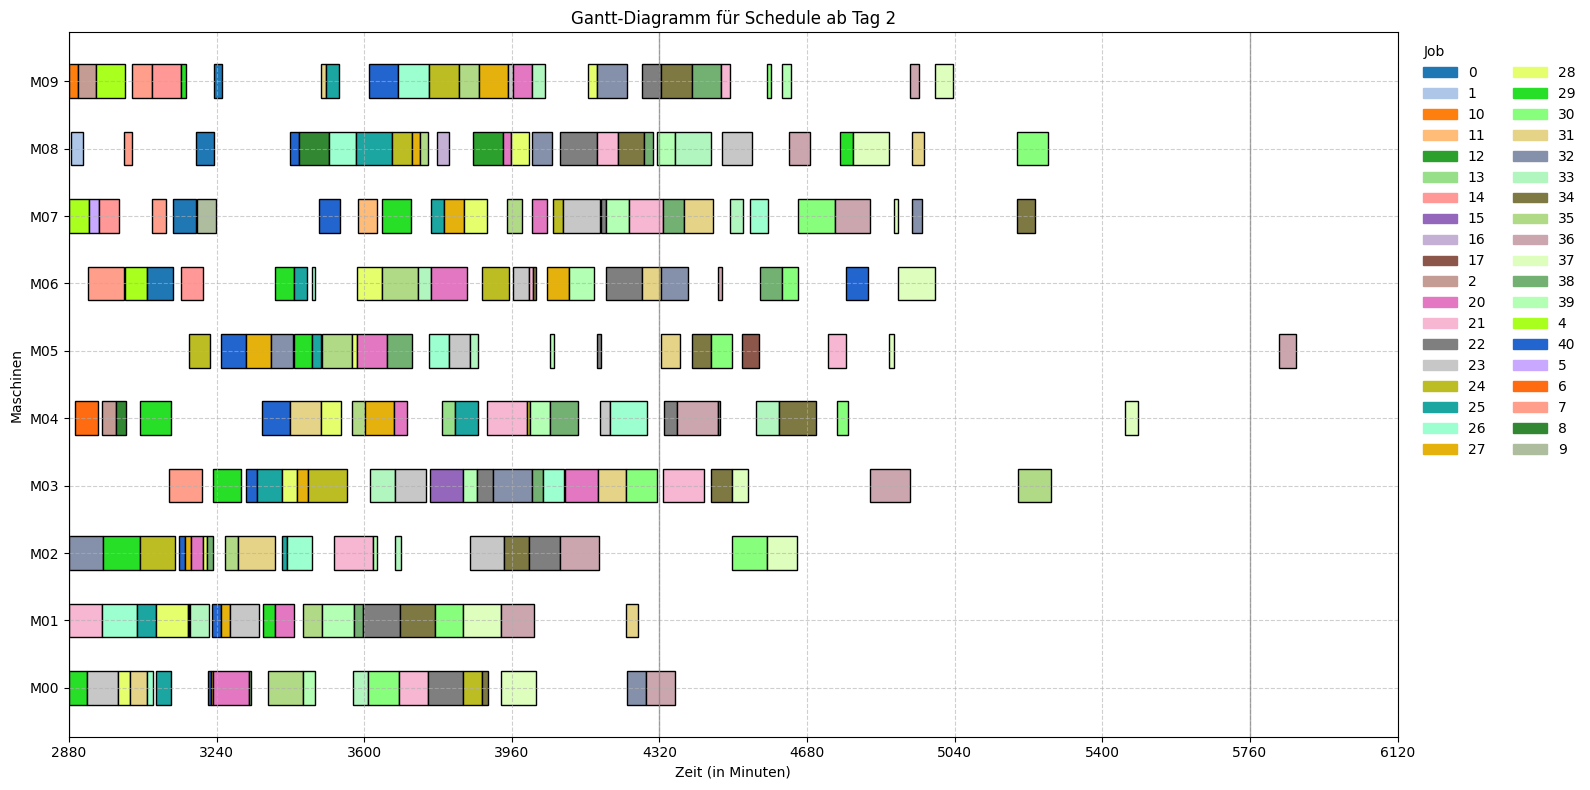

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         1
0              30
0 - 60          2
60 - 120        1
120 - 180       0
180 - 240       1
>240            3
Name: count, dtype: int64
[Day 2 00:00:00] Job 10 started on M09
[Day 2 00:00:00] Job 21 started on M01
[Day 2 00:00:00] Job 29 started on M00
[Day 2 00:00:00] Job 32 started on M02
[Day 2 00:00:00] Job 4 started on M07
[Day 2 00:05:00] Job 1 started on M08
[Day 2 00:15:00] Job 6 started on M04
[Day 2 00:17:32] Job 10 finished on M09 (after 17 minutes 32 seconds)
[Day 2 00:21:00] Job 2 started on M09
[Day 2 00:45:53] Job 1 finished on M08 (after 40 minutes 53 seconds)
[Day 2 00:47:00] Job 7 started on M06
[Day 2 00:58:12] Job 29 finished

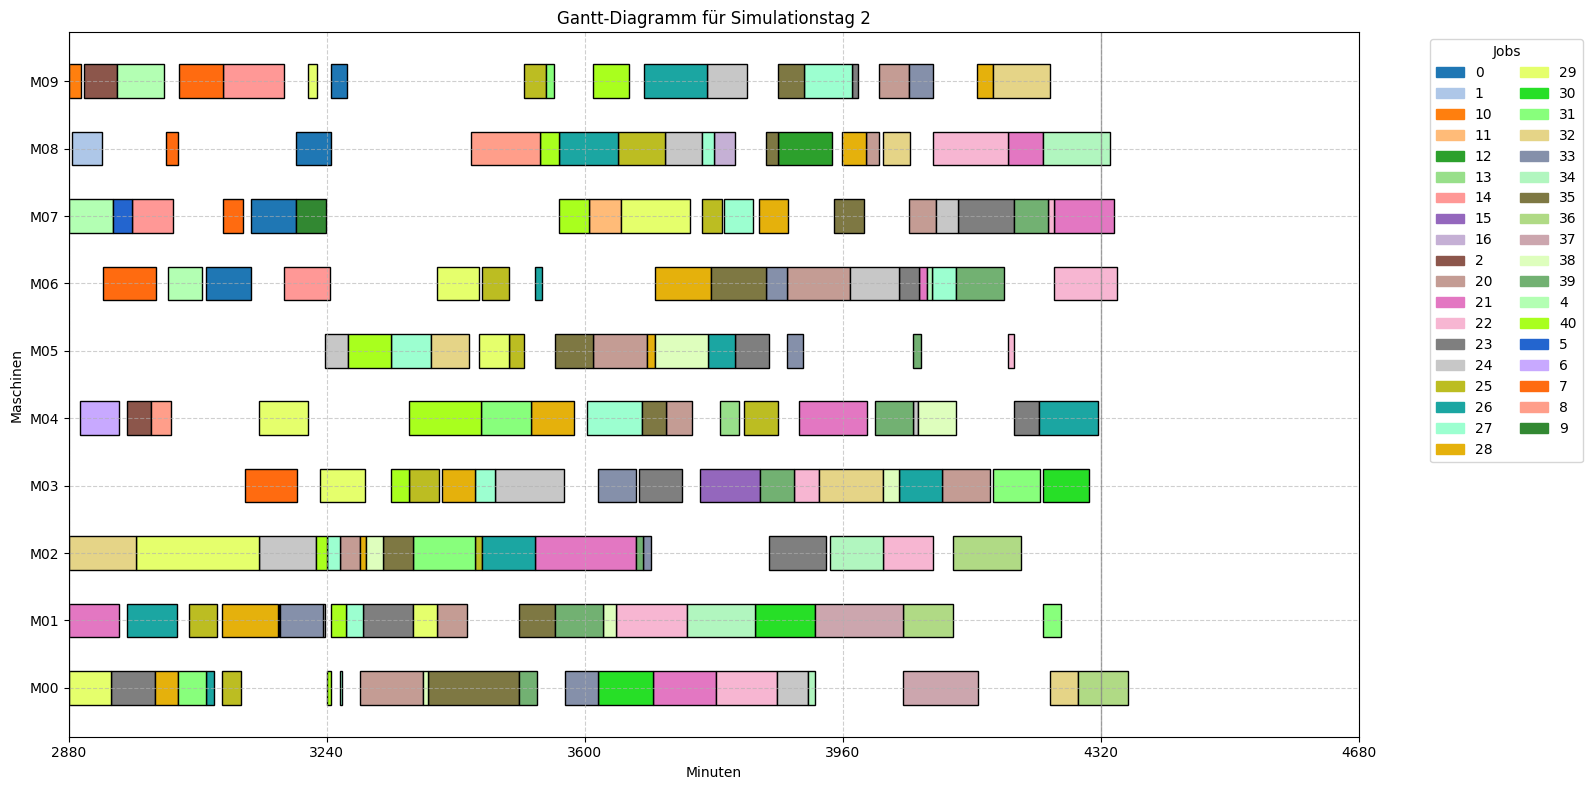

----------------------------------------------------------------------
Day 03: [4320, 5760)
[INFO] Anzahl Jobs mit Ready Time 4320: 17
[INFO] 54 zusätzliche Operationen hinzugefügt (gesamt: 224).
[INFO] 4 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 285.00
Best Objective Bound  : 285.00
Laufzeit              : 0.14 Sekunden


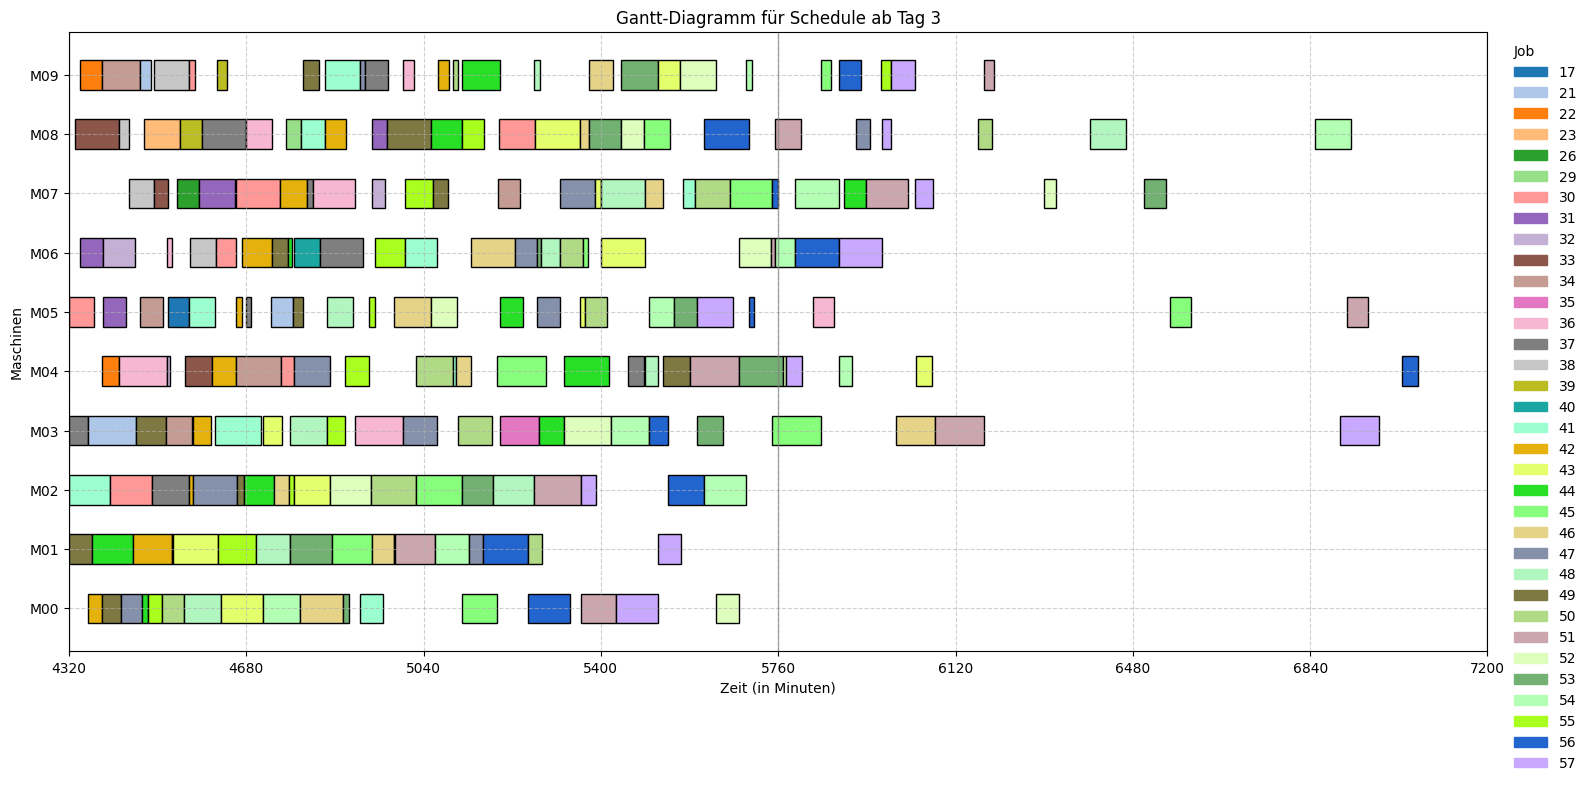

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              33
0 - 60          1
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 3 00:00:00] Job 30 started on M05
[Day 3 00:00:00] Job 37 started on M03
[Day 3 00:00:00] Job 41 started on M02
[Day 3 00:00:00] Job 49 started on M01
[Day 3 00:13:00] Job 33 started on M08
[Day 3 00:23:00] Job 22 started on M09
[Day 3 00:23:00] Job 31 started on M06
[Day 3 00:38:09] Job 37 finished on M03 (after 38 minutes 10 seconds)
[Day 3 00:39:00] Job 21 started on M03
[Day 3 00:39:00] Job 42 started on M00
[Day 3 00:43:02] Job 49 finished on M01 (after 43 minutes 02 seconds)
[Day 3 00:46:00] Job 44 st

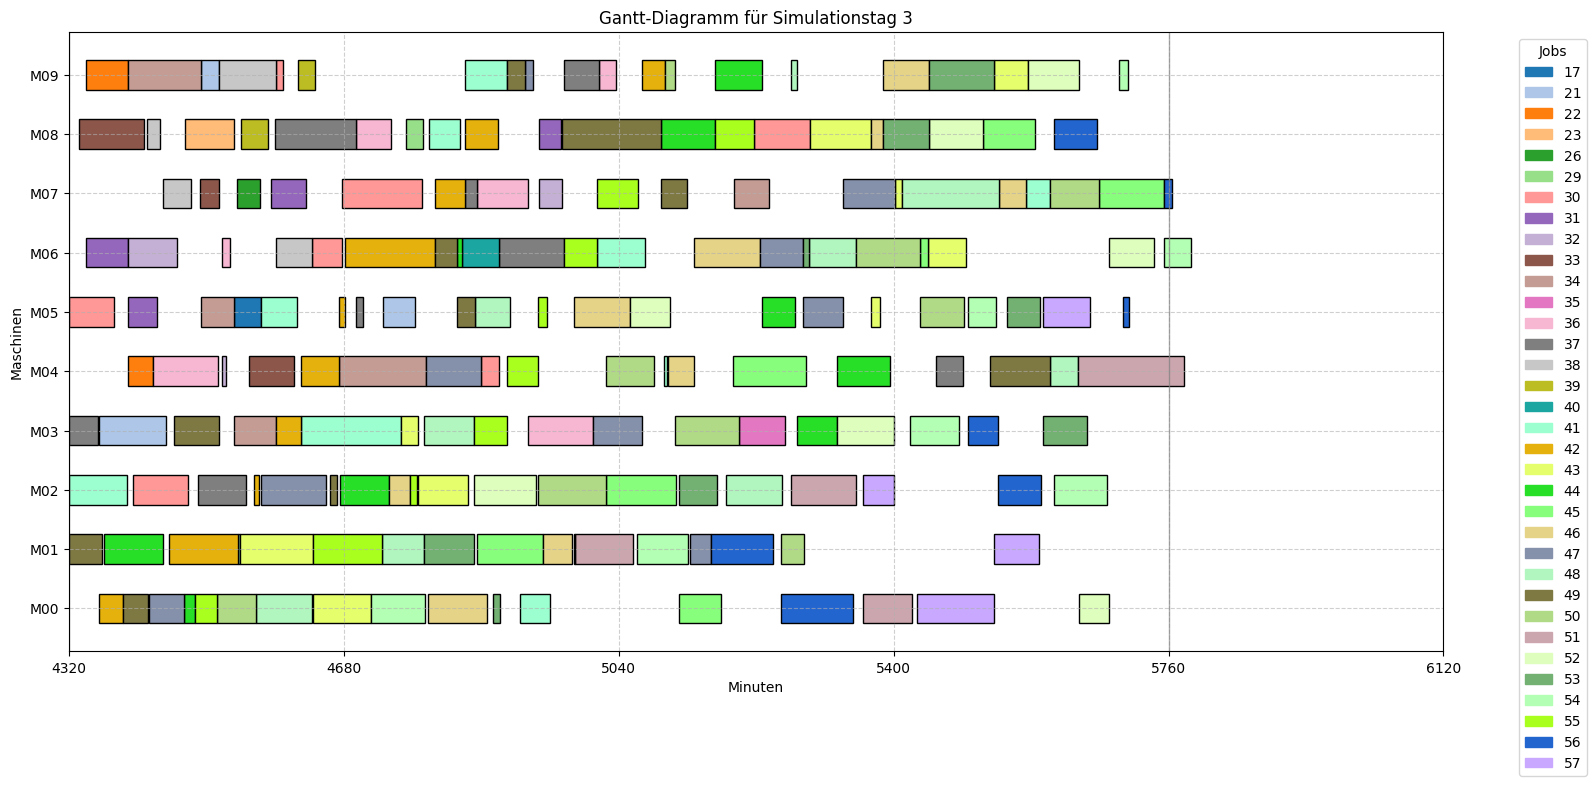

----------------------------------------------------------------------
Day 04: [5760, 7200)
[INFO] Anzahl Jobs mit Ready Time 5760: 17
[INFO] 33 zusätzliche Operationen hinzugefügt (gesamt: 203).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.13 Sekunden


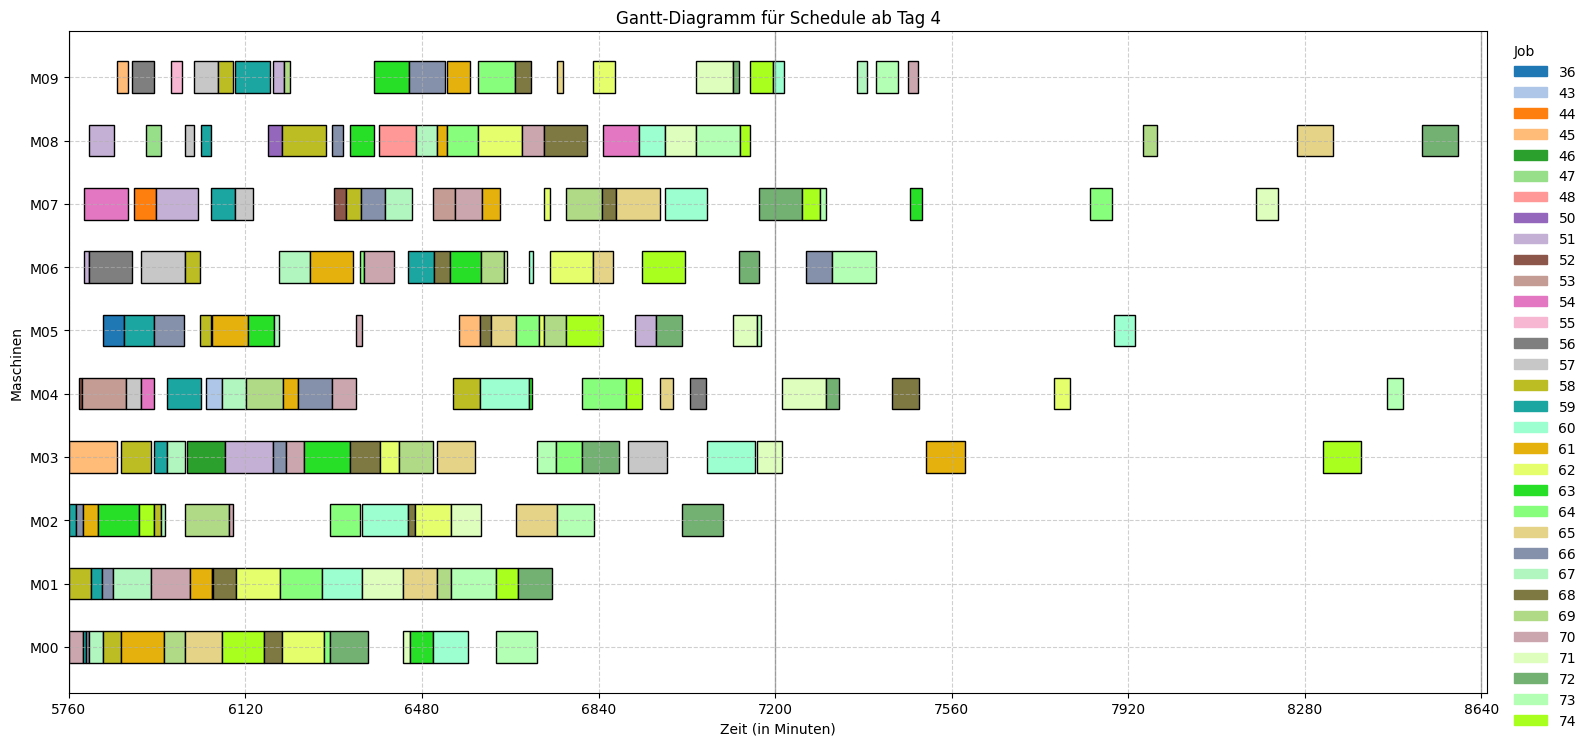

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              32
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 4 00:00:00] Job 45 started on M03
[Day 4 00:00:00] Job 58 started on M01
[Day 4 00:00:00] Job 59 started on M02
[Day 4 00:00:00] Job 70 started on M00
[Day 4 00:11:09] Job 59 finished on M02 (after 11 minutes 10 seconds)
[Day 4 00:14:00] Job 66 started on M02
[Day 4 00:20:00] Job 52 started on M04
[Day 4 00:26:31] Job 52 finished on M04 (after 06 minutes 32 seconds)
[Day 4 00:26:31] Job 53 started on M04
[Day 4 00:27:07] Job 66 finished on M02 (after 13 minutes 07 seconds)
[Day 4 00:28:00] Job 61 started on

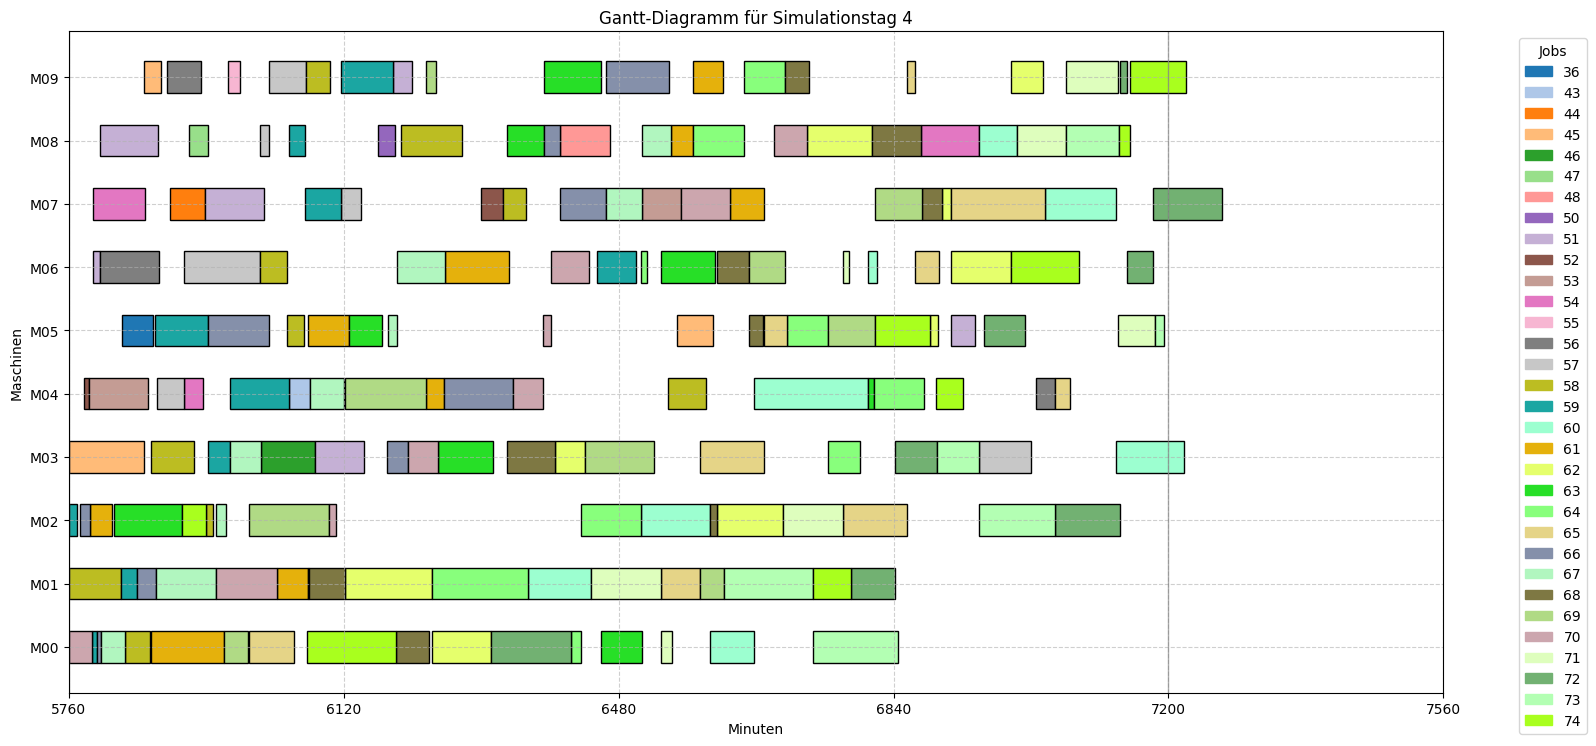

----------------------------------------------------------------------
Day 05: [7200, 8640)
[INFO] Anzahl Jobs mit Ready Time 7200: 21
[INFO] 23 zusätzliche Operationen hinzugefügt (gesamt: 233).
[INFO] 3 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 0.00
Best Objective Bound  : 0.00
Laufzeit              : 0.16 Sekunden


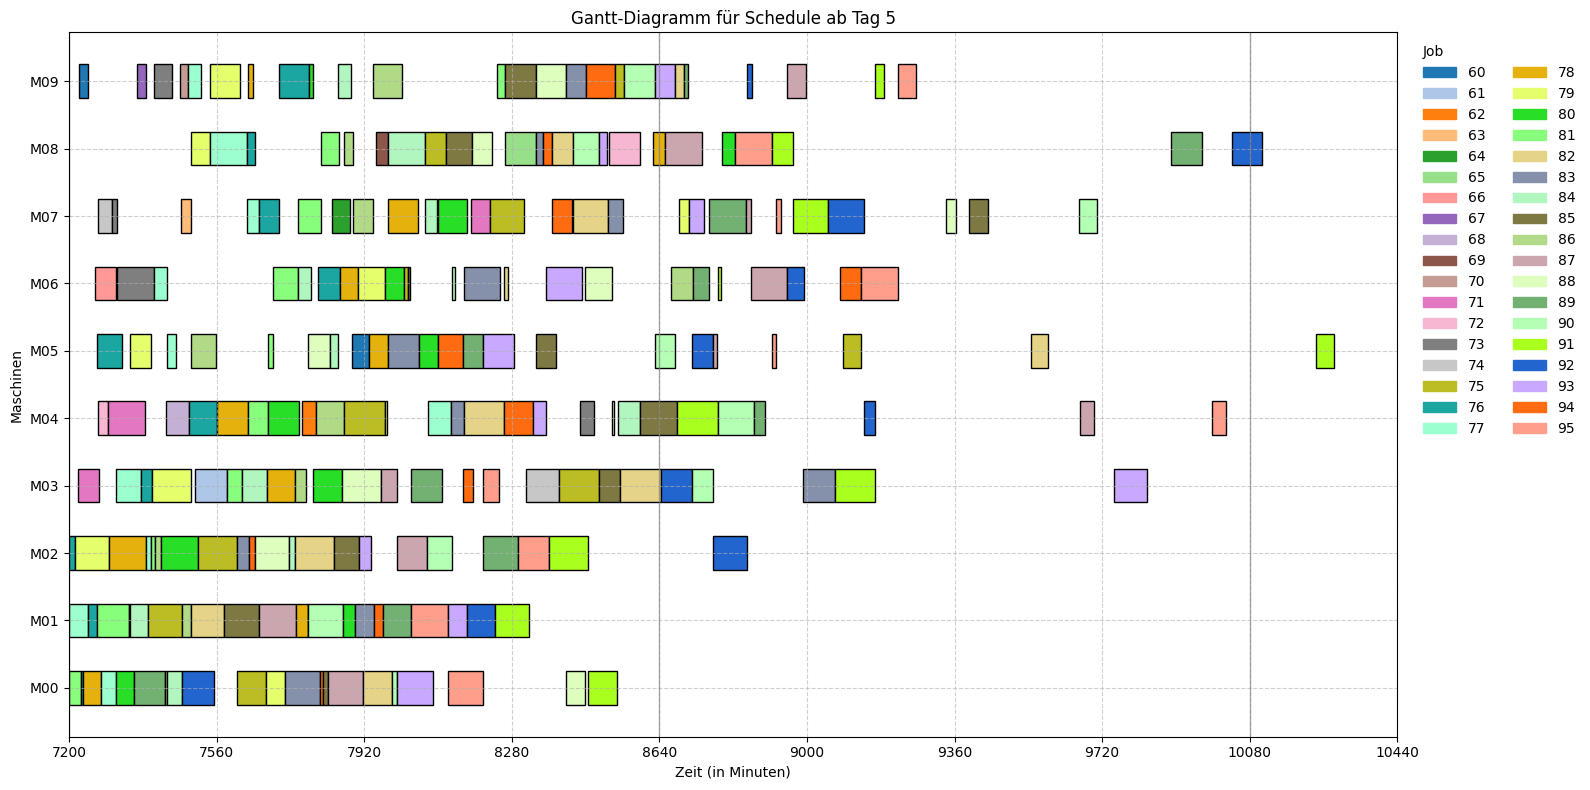

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         0
0              36
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 5 00:00:00] Job 76 started on M02
[Day 5 00:00:00] Job 77 started on M01
[Day 5 00:00:00] Job 81 started on M00
[Day 5 00:13:04] Job 76 finished on M02 (after 13 minutes 04 seconds)
[Day 5 00:14:00] Job 79 started on M02
[Day 5 00:21:00] Job 71 started on M03
[Day 5 00:24:00] Job 60 started on M09
[Day 5 00:31:33] Job 81 finished on M00 (after 31 minutes 33 seconds)
[Day 5 00:31:33] Job 76 started on M00
[Day 5 00:36:17] Job 77 finished on M01 (after 36 minutes 17 seconds)
[Day 5 00:37:28] Job 76 finished o

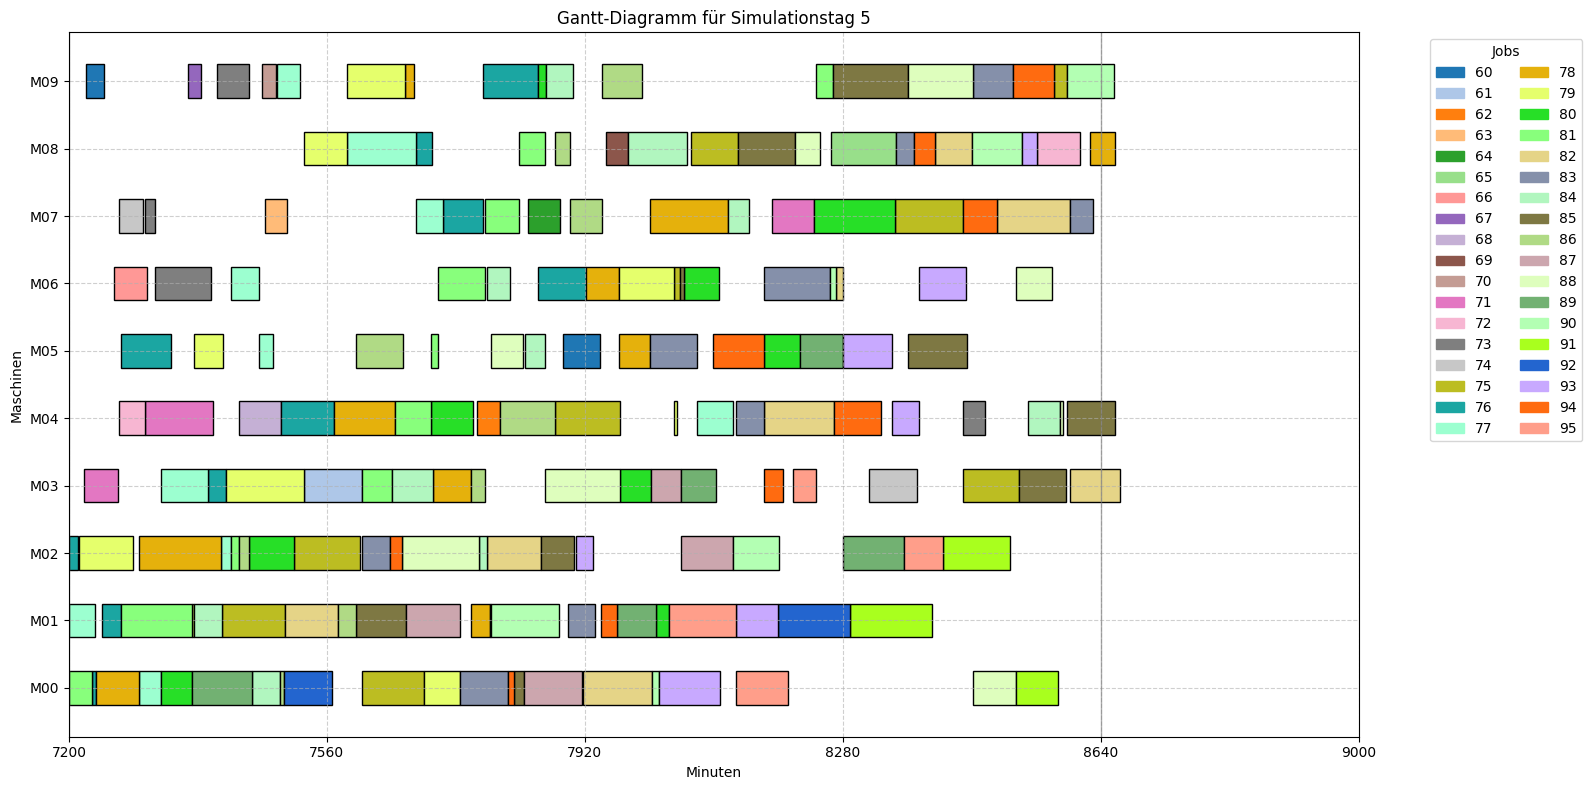

----------------------------------------------------------------------
Day 06: [8640, 10080)
[INFO] Anzahl Jobs mit Ready Time 8640: 29
[INFO] 49 zusätzliche Operationen hinzugefügt (gesamt: 339).
[INFO] 4 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : OPTIMAL
Objective Value       : 87.00
Best Objective Bound  : 87.00
Laufzeit              : 3.55 Sekunden


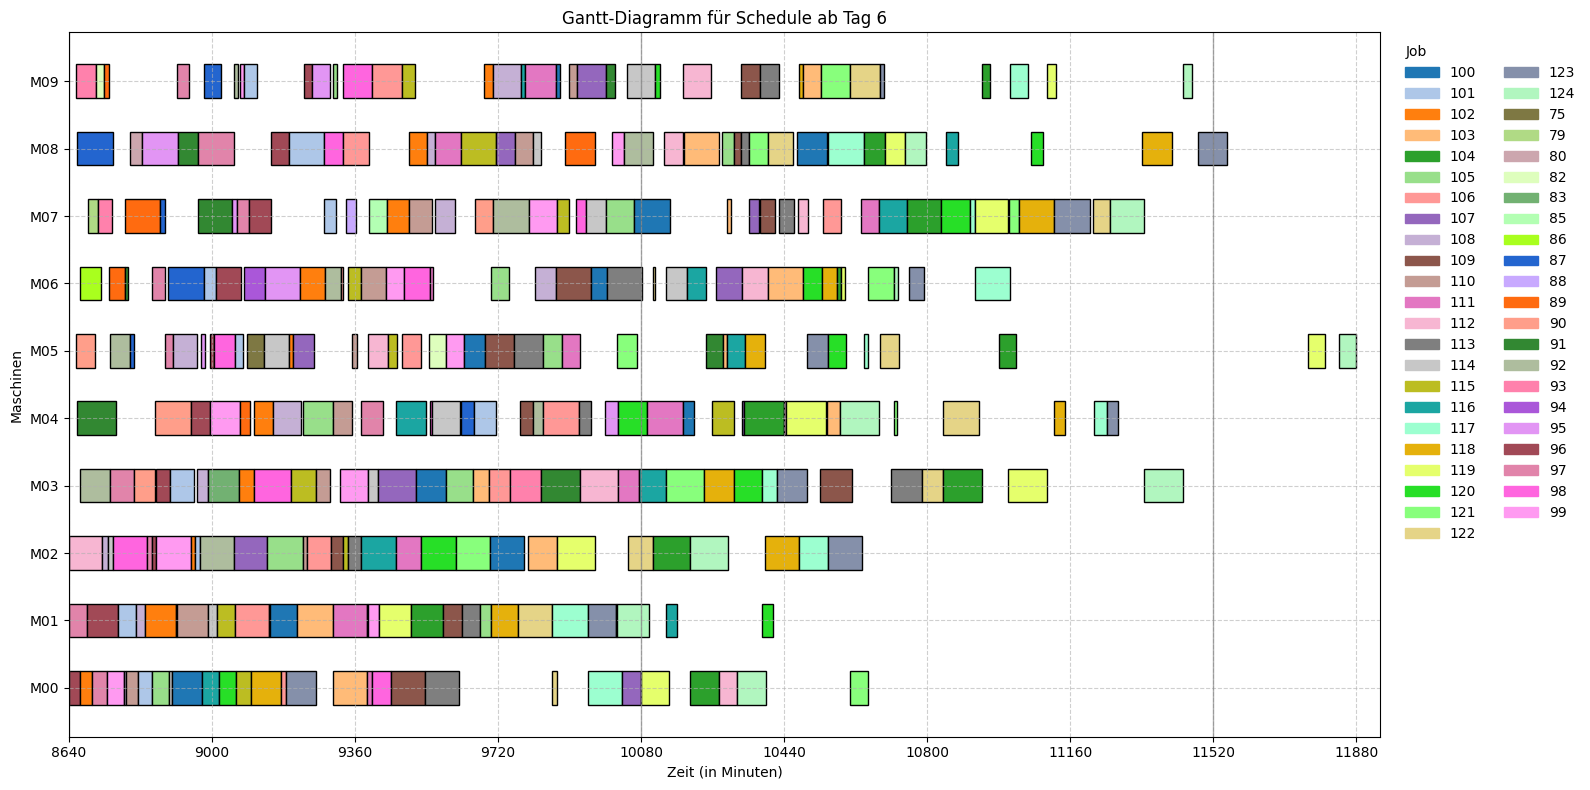

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         2
0              43
0 - 60          0
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 6 00:00:00] Job 112 started on M02
[Day 6 00:00:00] Job 96 started on M00
[Day 6 00:00:00] Job 97 started on M01
[Day 6 00:19:00] Job 90 started on M05
[Day 6 00:19:00] Job 93 started on M09
[Day 6 00:20:00] Job 87 started on M08
[Day 6 00:20:00] Job 91 started on M04
[Day 6 00:22:31] Job 96 finished on M00 (after 22 minutes 31 seconds)
[Day 6 00:27:00] Job 92 started on M03
[Day 6 00:29:00] Job 102 started on M00
[Day 6 00:29:00] Job 86 started on M06
[Day 6 00:35:34] Job 97 finished on M01 (after 35 minut

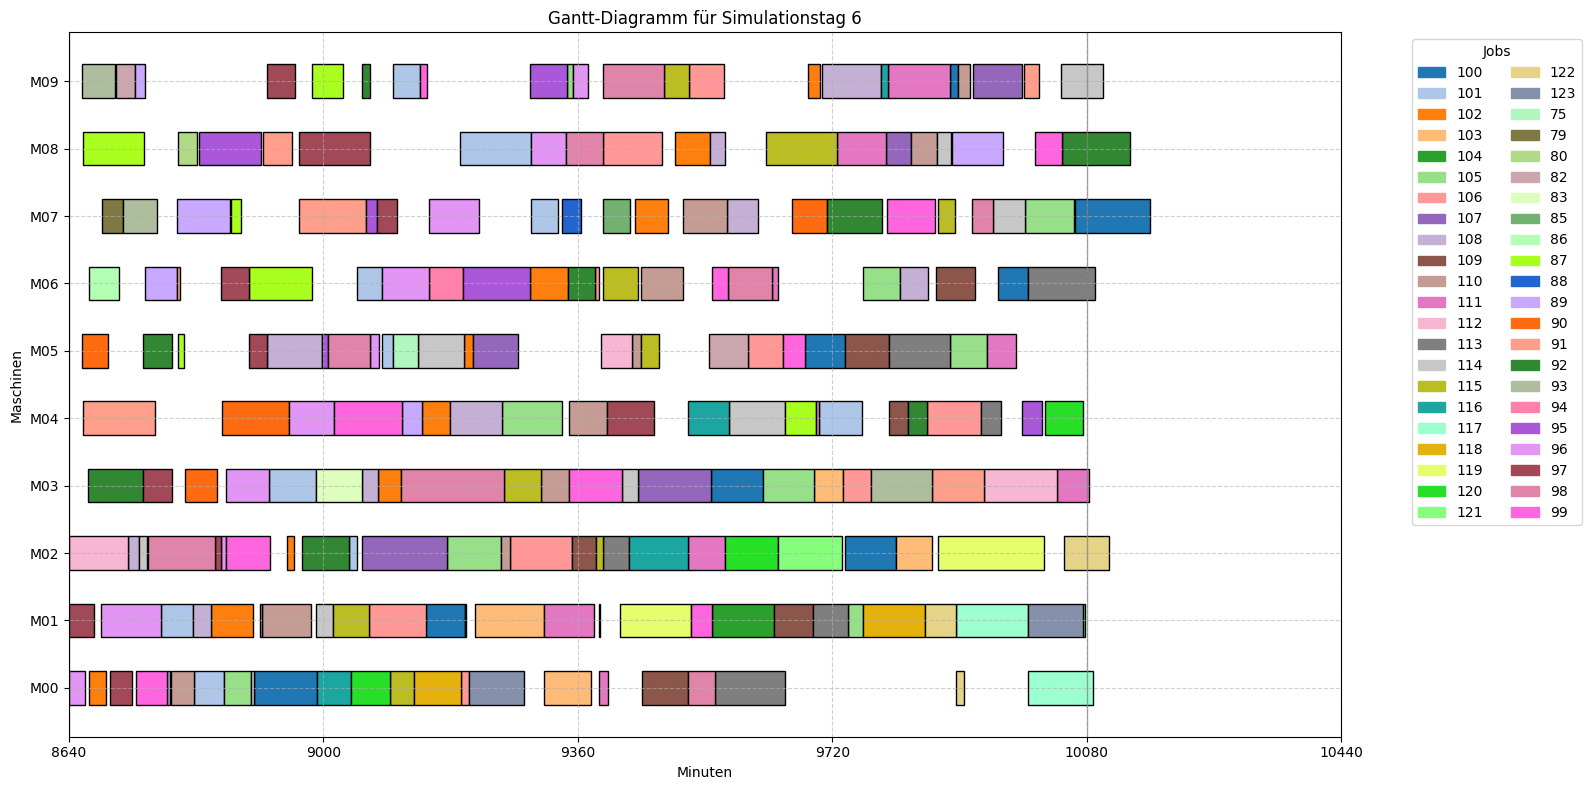

----------------------------------------------------------------------
Day 07: [10080, 11520)
[INFO] Anzahl Jobs mit Ready Time 10080: 22
[INFO] 112 zusätzliche Operationen hinzugefügt (gesamt: 332).
[INFO] 7 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : FEASIBLE
Objective Value       : 270.00
Best Objective Bound  : 129.00
Laufzeit              : 1800.49 Sekunden


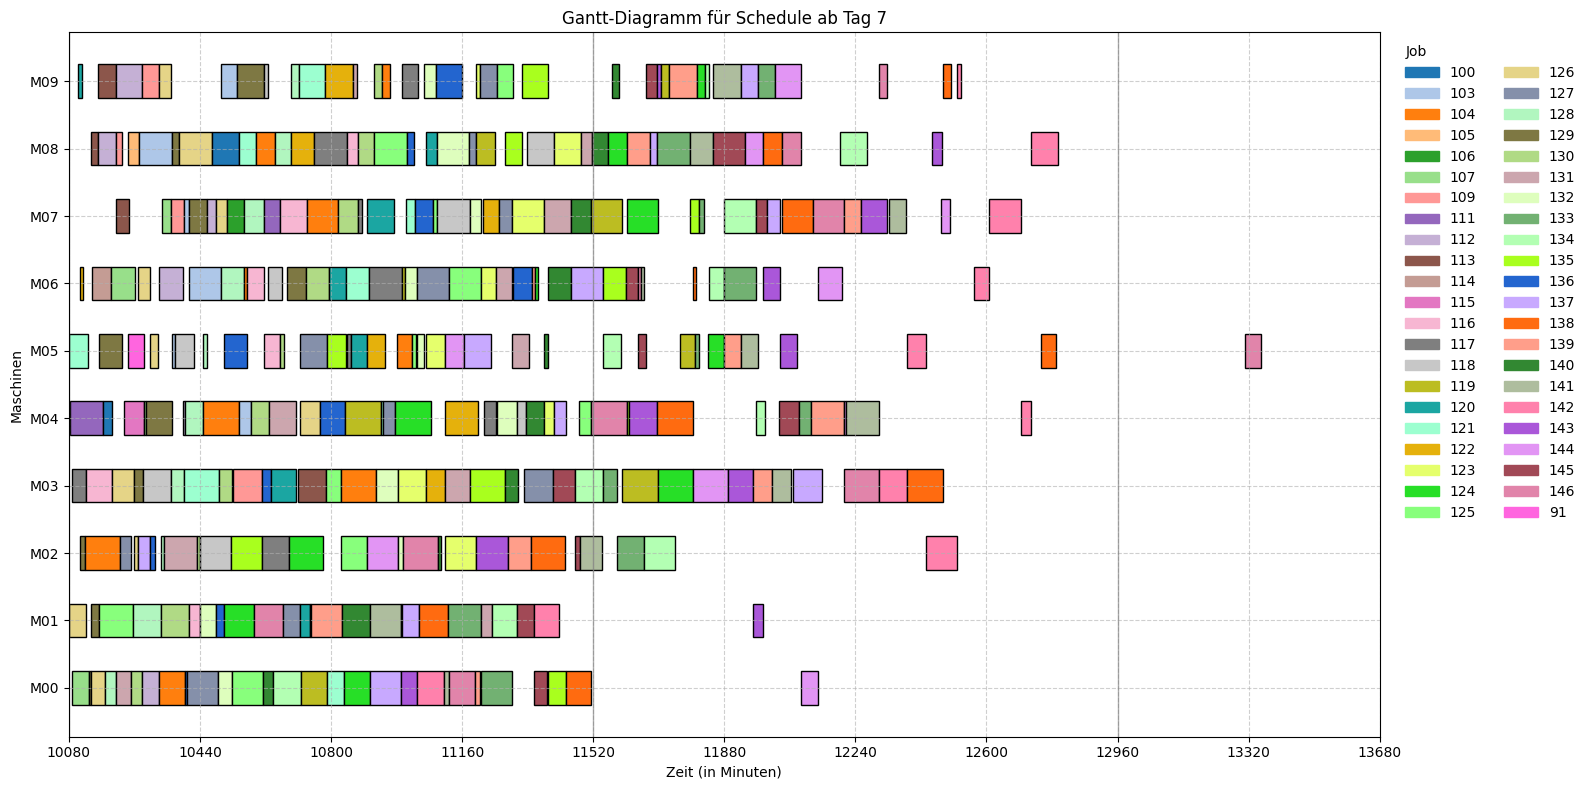

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      1
-60 - 0        11
0              31
0 - 60          1
60 - 120        0
120 - 180       0
180 - 240       0
>240            0
Name: count, dtype: int64
[Day 7 00:00:00] Job 121 started on M05
[Day 7 00:00:00] Job 126 started on M01
[Day 7 00:03:00] Job 111 started on M04
[Day 7 00:09:00] Job 107 started on M00
[Day 7 00:09:00] Job 117 started on M03
[Day 7 00:24:00] Job 120 started on M09
[Day 7 00:31:00] Job 122 started on M06
[Day 7 00:31:00] Job 129 started on M02
[Day 7 00:35:50] Job 120 finished on M09 (after 11 minutes 50 seconds)
[Day 7 00:38:41] Job 122 finished on M06 (after 07 minutes 41 seconds)
[Day 7 00:44:17] Job 126 finished on M01 (after 44 minu

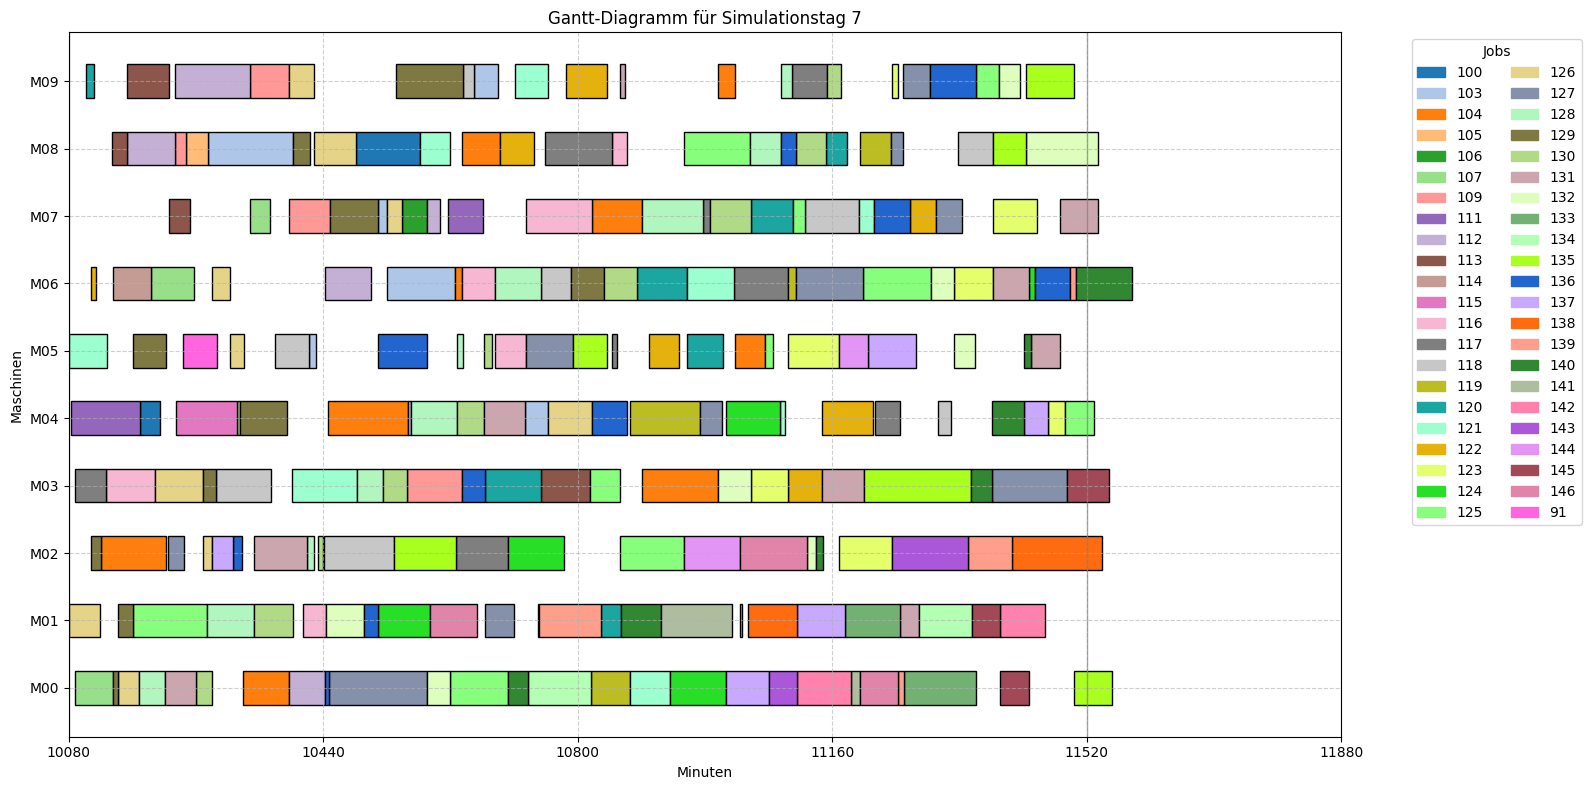

----------------------------------------------------------------------
Day 08: [11520, 12960)
[INFO] Anzahl Jobs mit Ready Time 11520: 19
[INFO] 99 zusätzliche Operationen hinzugefügt (gesamt: 289).
[INFO] 7 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : FEASIBLE
Objective Value       : 6202.00
Best Objective Bound  : 5140.00
Laufzeit              : 1800.54 Sekunden


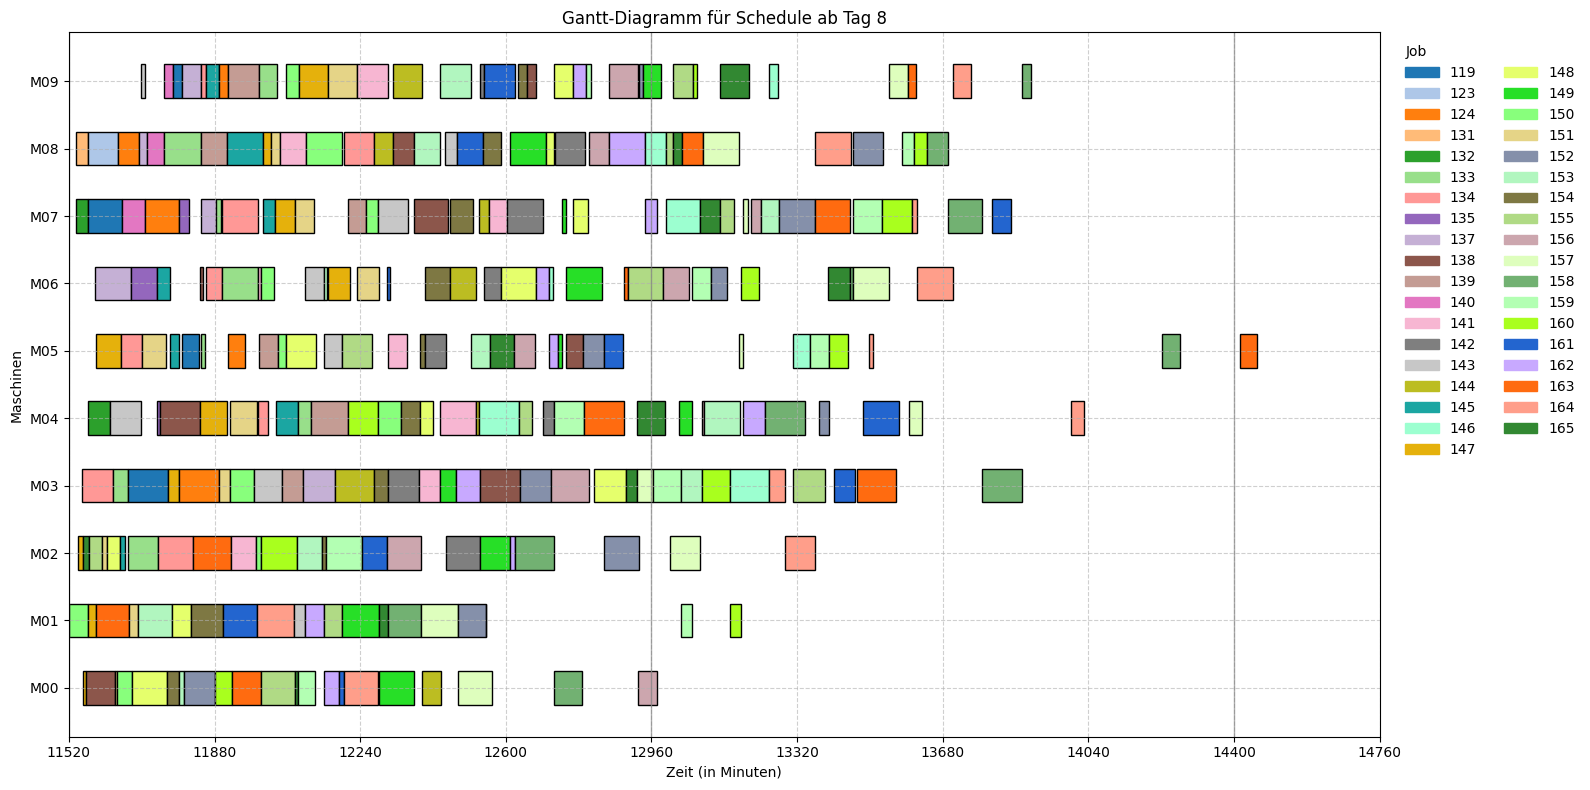

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     0
-120 - -60      0
-60 - 0         5
0              20
0 - 60          6
60 - 120        2
120 - 180       1
180 - 240       2
>240            1
Name: count, dtype: int64
[Day 8 00:00:00] Job 150 started on M01
[Day 8 00:17:00] Job 131 started on M08
[Day 8 00:17:00] Job 132 started on M07
[Day 8 00:22:00] Job 147 started on M02
[Day 8 00:32:00] Job 134 started on M03
[Day 8 00:36:22] Job 147 finished on M02 (after 14 minutes 22 seconds)
[Day 8 00:36:22] Job 165 started on M02
[Day 8 00:36:22] Job 147 started on M00
[Day 8 00:41:27] Job 147 finished on M00 (after 05 minutes 05 seconds)
[Day 8 00:42:00] Job 138 started on M00
[Day 8 00:47:08] Job 132 finished on M07 (after 30 minu

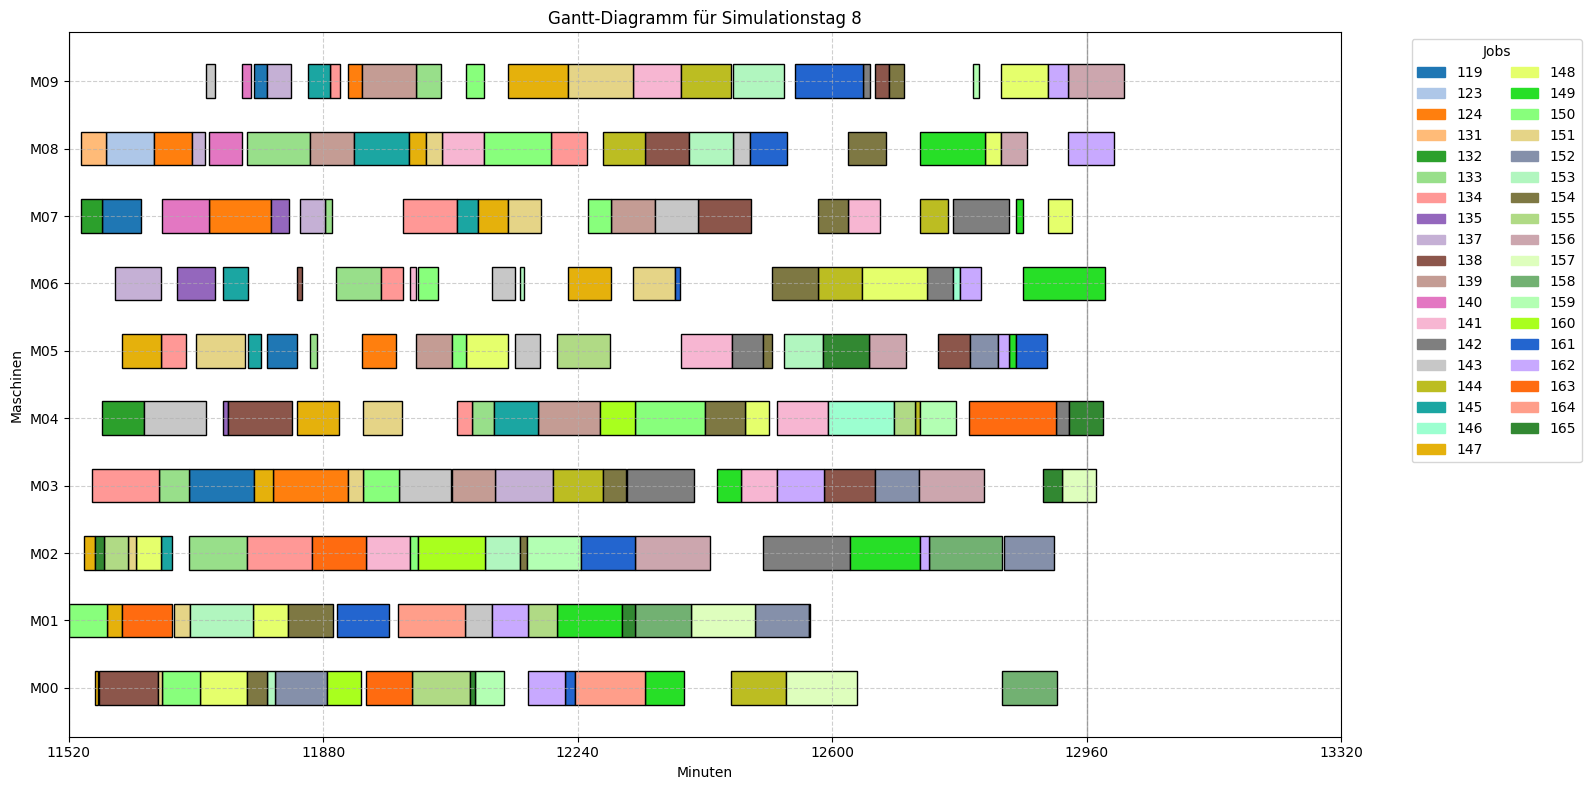

----------------------------------------------------------------------
Day 09: [12960, 14400)
[INFO] Anzahl Jobs mit Ready Time 12960: 27
[INFO] 76 zusätzliche Operationen hinzugefügt (gesamt: 346).
[INFO] 5 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.

Solver-Status         : FEASIBLE
Objective Value       : 16811.00
Best Objective Bound  : 8051.00
Laufzeit              : 1824.50 Sekunden


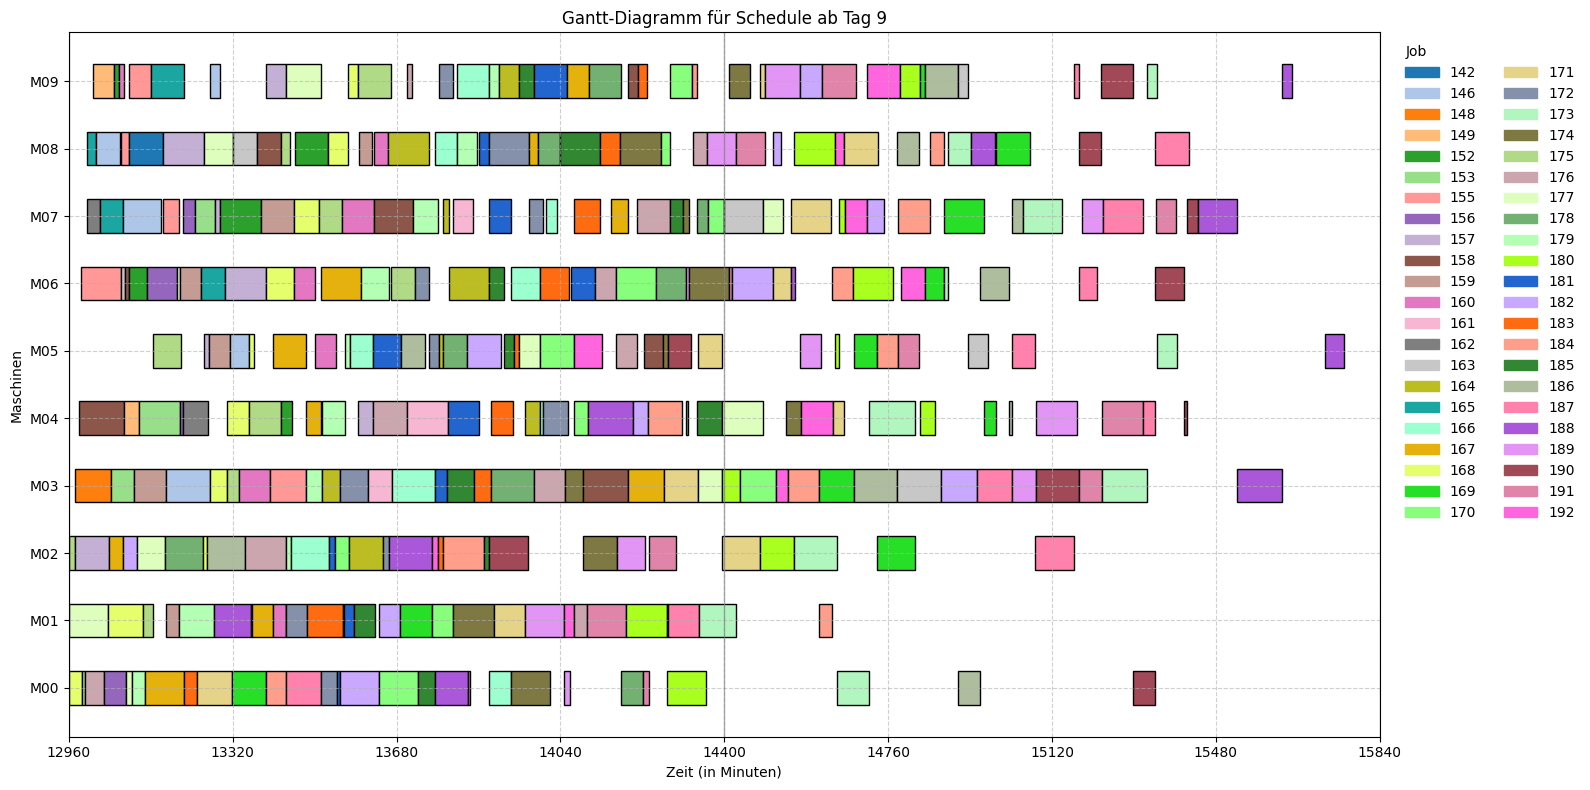

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

label
<-240           0
-240 - -180     0
-180 - -120     1
-120 - -60      0
-60 - 0        10
0              10
0 - 60         12
60 - 120        2
120 - 180       2
180 - 240       1
>240            6
Name: count, dtype: int64
[Day 9 00:00:00] Job 168 started on M00
[Day 9 00:00:00] Job 175 started on M02
[Day 9 00:00:00] Job 177 started on M01
[Day 9 00:09:01] Job 175 finished on M02 (after 09 minutes 02 seconds)
[Day 9 00:13:00] Job 148 started on M03
[Day 9 00:14:00] Job 157 started on M02
[Day 9 00:23:00] Job 158 started on M04
[Day 9 00:26:00] Job 155 started on M06
[Day 9 00:27:17] Job 168 finished on M00 (after 27 minutes 18 seconds)
[Day 9 00:29:00] Job 175 started on M00
[Day 9 00:34:38] Job 175 finished on M00 (after 05 minu

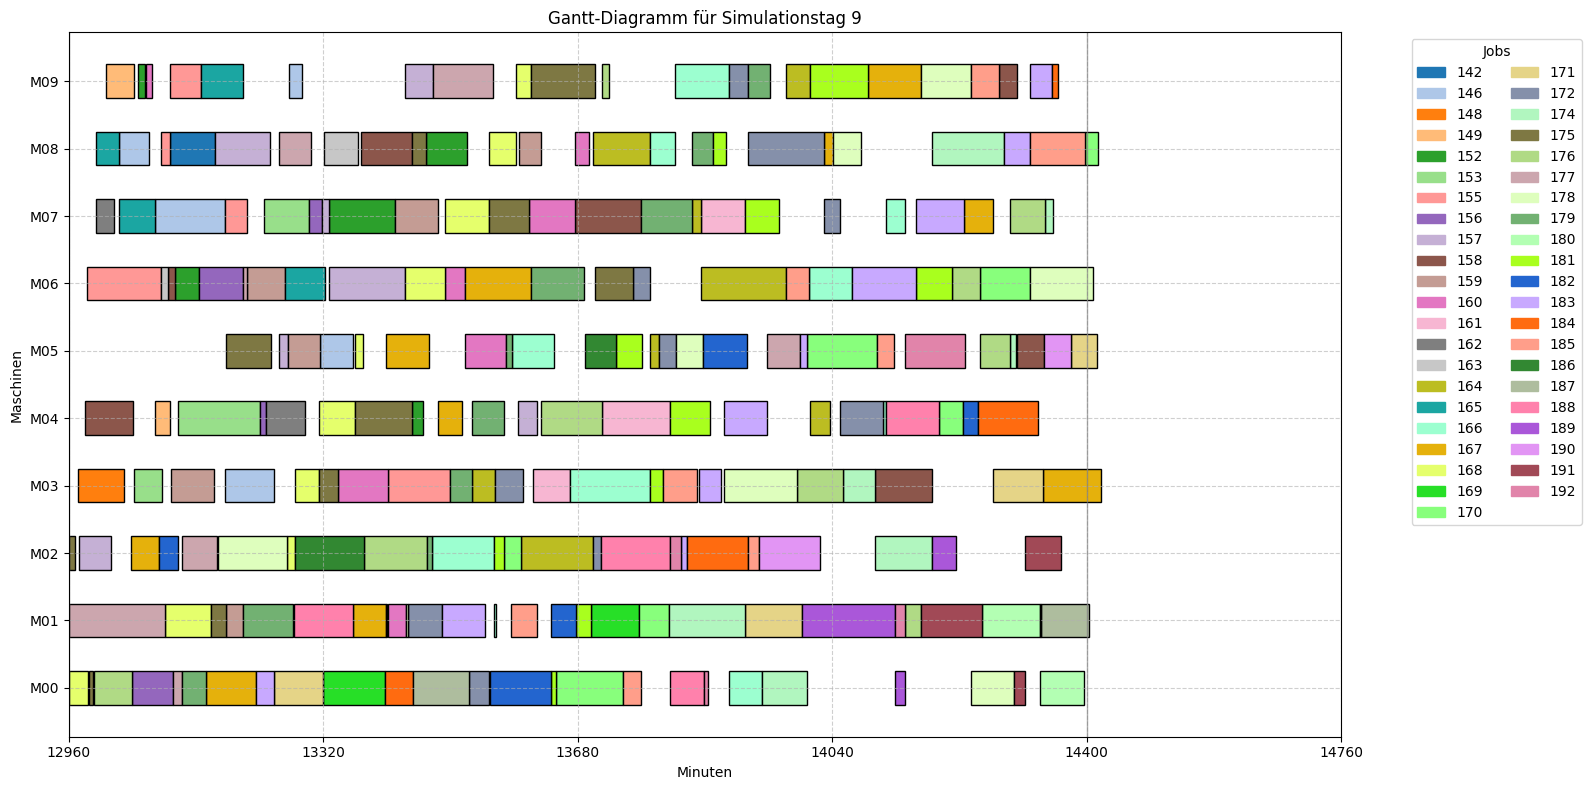

----------------------------------------------------------------------
Day 10: [14400, 15840)
[INFO] Anzahl Jobs mit Ready Time 14400: 22
[INFO] 109 zusätzliche Operationen hinzugefügt (gesamt: 329).
[INFO] 5 laufende Operation(en) aus vorherigen Tagen enden erst nach Tagesbeginn.


In [ ]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length*day_numb 
    day_end = day_start + day_length
    print(f"Day {day_numb:02d}: [{day_start}, {day_end})")

    # ------------------------ I. Operationsvorbereitung ------------------------
    #----------------------------------------------------------------------------
    
    # ---------- a) Filterung nach der aktuellen "Ready Time" ----------
    df_jssp_curr, df_job_times_curr = process_filter.jobs_by_ready_time(df_job_times_all, df_jssp_all, ready_time = day_start, verbose=True)

    
    # ---------- b) Zusammenführung mit unerledigten Operationen -------
    df_jssp_curr = process_filter.extend_with_undone_operations(df_jssp_curr, df_undone, verbose=True)
    df_times_curr = process_filter.update_times_after_operation_changes(df_job_times_all, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = process_filter.get_operations_running_into_day(df_execution, day_start, verbose=True)

    # ------------------------ III. Rescheduling --------------------------------
    #----------------------------------------------------------------------------

    df_schedule = cp_late_reschedule.solve_jssp_by_tardiness_and_earliness_with_fixed_ops(df_jssp_curr, df_times_curr, 
                                                                                          df_execution_important, w_t = 5,
                                                                                          reschedule_start = day_start, 
                                                                                          msg=False, timeLimit=max_time, gapRel= 0.001)
    
    file = file_template.format(text= f"schedule_{day_numb:02d}")
    df_schedule.to_csv(data_path / file, index=False)
    
    show.plot_gantt(df_schedule, perspective="Machine", title=f"Gantt-Diagramm für Schedule ab Tag {day_numb}")
    check.all_in_one(df_schedule)

    last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
    print(show.count_column_grouped(last_ops, "Lateness", max_val = 240, steps= 60))

    # ------------------------ IV. Simulation -----------------------------------
    simulation = ProductionSimulation(df_schedule, sigma=0.2)
    df_execution = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}")
    else:
        print(f"Nothing executed on day {day_numb}")

    df_undone = process_filter.get_unexecuted_operations(df_schedule, df_execution)
    print("-"*70)